                                    #### `in The Name of God                                            `

In [ ]:
!git clone https://github.com/cloner174/mr.DGA.git

In [ ]:
%cd mr.DGA

In [4]:
import os
import cv2
import time
import warnings
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

#### path to main working files:

In [3]:
emo_map_guide_path = 'data/output/csv/images_emo_map.csv'
valid_data_path = 'data/output/csv/Data-Valid-from-3.6.1.csv.zip'

#### Loading Valid Data:

In [ ]:
data = pd.read_csv(valid_data_path, compression='zip')
emo_map_guide = pd.read_csv(emo_map_guide_path, index_col = 4)
print('Data Valid shape: \n' ,data.shape,'\n')
print('Emotion Map-Guide shape: \n' ,emo_map_guide.shape,'\n')
time.sleep(2)
print('Data valid type of pixels: \n' ,type(data[' pixels'][0]),'\n')
time.sleep(2)
print('Data valid head: \n')
print(data.head())
time.sleep(3)
print('\nEmotion Map-Guide head: \n')
print(emo_map_guide.head())
time.sleep(1)

In [ ]:
data = data.set_axis(['indx', 'emotion', 'pixels'], axis = 1)
print('Data Valid head after renaming cols: \n')
print(data.head(),'\n')

In [ ]:
data = data.set_axis(['indx', 'emotion', 'pixels'], axis = 1)
print('Data Valid head after renaming cols: \n\n','\n'), data.head(2)

In [7]:
def strings_with_number_inside( data,
                                    index_iloc = None,
                                    label_iloc = None,
                                    column_range_starts : int = 0,
                                    column_range_ends : int = None,
                                    seperator = None):
        start = column_range_starts
        end = int( data.shape[1] ) if column_range_ends is None else column_range_ends
        new_data = []
        try :
            for i in range( data.shape[0] ) :
                temp_new_data = {}
                for j in range( start, end ) :
                    cells_real_values = np.array(data.iloc[i, j].split(sep = seperator), dtype='uint8')
                    if index_iloc is not None:
                      temp_new_data['index'] = data.iloc[i, index_iloc]
                    else:
                      temp_new_data['index'] = i
                    temp_new_data['pixels'] = cells_real_values
                    if label_iloc:
                      temp_new_data['emotin'] = data.iloc[i, label_iloc]
                new_data.append(temp_new_data)
            return new_data
        except:
            if isinstance( data , np.array ) :
                pass
            else:
                raise TypeError( " data just could be  PandasDataFrame  or  NumpyArray  ! ")

In [8]:
data.head()

,indx,emotion,pixels
0,7059,3,30 26 26 26 26 26 25 24 25 26 26 26 26 27 29 2...
1,26452,5,0 0 0 4 26 29 23 40 100 105 103 103 103 105 11...
2,31551,3,31 30 31 33 41 47 61 74 79 59 59 112 144 134 1...
3,1481,4,32 29 27 30 32 33 40 49 65 86 48 14 8 6 10 17 ...
4,20543,3,60 29 24 40 38 36 29 32 28 25 31 20 23 25 23 2...


In [9]:
data_fixed = strings_with_number_inside(data, index_iloc = 0, label_iloc = 1, column_range_starts = 2)

In [ ]:
data_fixed = pd.DataFrame(data_fixed)
print('Data Valid head after fixing the type of each pixel rows: \n\n')
print(data_fixed.head(),'\n')
time.sleep(2)
print('\n', 'We are going to call the fixed-Data-Valid , -> data_fixed <- since now on : \n\n' ,'\n')

#### Some fixing of data to be ready


In [ ]:
data_fixed = data_fixed.set_index('index')
data_fixed.sort_index(inplace=True)
emo_map_guide.sort_index(inplace=True)
print(emo_map_guide.head(3))
print('\n', data_fixed.head(3))

#### Adding additional information to our fixed_data

In [ ]:
emo_map_guide.head()

In [13]:
data_fixed['name'] = emo_map_guide['name']
data_fixed['path'] = emo_map_guide['path']
data_fixed['back_up_emotion'] = emo_map_guide['emotion']

data_fixed.head()

In [ ]:
unmatch_emotions_police = []

for any_ in data_fixed.index:
  if data_fixed.loc[any_, 'emotin'] != data_fixed.loc[any_, 'back_up_emotion']:
    unmatch_emotions_police.append(any_)
    warnings.warn(f" One or more NoN-Match Items founded in data// this time index number : {any_}")
  else:
    pass
if len(unmatch_emotions_police)==0:
  print(" Data was Seccessfuly Scaned and there is NO unmatch items. ")

*Some Function to We Use Them Further in This Script :*

In [17]:
def show(image_array, are_you_using_colab, show_before, show_after, face):
    if are_you_using_colab:
        try:
            from google.colab.patches import cv2_imshow
        except:
            print('google.colab is not in your local env')
            return 0
        if show_before:
            print('Before Cropping :')
            cv2_imshow(image_array)
        if show_after:
            print('After Cropping :')
            cv2_imshow(face)
    else:
        try:
            plt.imshow(face)
        except:
            print("sorry, face was there but we are just able to show you inside google colab.")
            time.sleep(1)
            print(" Try manually use cv2.imshow(SOME_STRING, VALUE_FROM_THIS_METHOD) function with the value returned from this method to see the result!")
    return 0

In [18]:
def save_array_to_file(array, directory, filename):

    if not os.path.exists(directory):
        os.makedirs(directory)
    path = os.path.join(directory, filename)
    np.save(path, array)
    return path

#### pre-trained face detection model for face area cropping


In [19]:
model = "models/face_detector_advance/res10_300x300_ssd_iter_140000.caffemodel"
config = "models/face_detector_advance/deploy.prototxt.txt"
net = cv2.dnn.readNetFromCaffe(config, model)

In [20]:

def addjust_and_crop_faces(image_array_input, directory = 'data/output/csv/croped-arrays', image_size=(48,48), show_=False,
                            return_cropped_array=False, save_one_dimentioal=False,
                            name_or_id='id', target_to_write=None,
                            target_name_for_return_dict='target', index=0,
                            show_after=True, show_before=True, are_you_using_colab=True):
    image_array = np.array(image_array_input, dtype=np.uint8).reshape(image_size[0], image_size[1])
    image_rgb = np.stack((image_array,) * 3, axis=-1)
    blob = cv2.dnn.blobFromImage(image_rgb)
    net.setInput(blob)
    detections = net.forward()
    face = None
    if detections.shape[2] > 0:
        confidence = detections[0, 0, 0, 2]
        if confidence > 0.5:
            box = detections[0, 0, 0, 3:7] * np.array([image_array.shape[1], image_array.shape[0], image_array.shape[1], image_array.shape[0]])
            (startX, startY, endX, endY) = box.astype("int")
            face = image_array[startY:endY, startX:endX]

    if face is not None and face.size > 0:
        try:
            cropped_face_image = Image.fromarray(face)
            if cropped_face_image.width < 5 and cropped_face_image.height > 15:
                return None
            elif cropped_face_image.height < 5 and cropped_face_image.width > 15:
                return None
            else:
                pass
        except:
            return None
        if return_cropped_array:
            if save_one_dimentioal:
                face = face.reshape(-1)
        else:
            if show_:
                show(image_array,are_you_using_colab,show_before, show_after,face )
            else:
                return 0
        filename = f"{name_or_id}_{index}.npy"
        path_to_face_array = save_array_to_file(face, directory, filename)
        cropped_array = {
            'index': index,
            'name': name_or_id,
            'pixel': path_to_face_array,
            target_name_for_return_dict: target_to_write
        }
        if show_:
            show(image_array,are_you_using_colab,show_before, show_after,face )
        return cropped_array
    else:
        return None




##### * test:*



In [ ]:

image_array = data_fixed['pixels'][4]

test_cropped_face = addjust_and_crop_faces(image_array, return_cropped_array=True)

print(type(test_cropped_face), '\n','columns in result data : ',list(test_cropped_face.keys()), '\n',test_cropped_face['pixel'])#, test_cropped_face['pixel'].shape

### loop inside all!

In [22]:
no_face_after_addjust = []
cropped_array = []
for indx, cols in data_fixed.iterrows():
  image_array = cols['pixels']
  face_temp = addjust_and_crop_faces(image_array,
                                      directory = 'data/output/csv/Cropped Arrays/',
                                      return_cropped_array=True,
                                      name_or_id = cols['name'],
                                      target_to_write = cols['emotin'],
                                      target_name_for_return_dict = 'emotion',
                                      index = indx)
  if face_temp is None :
    no_face_after_addjust.append(indx)
  else:
    cropped_array.append(face_temp)

In [ ]:
print('Length of Not Faces after Crop : ', len(no_face_after_addjust))
print('Length of Faces after Crop : ', len(cropped_array))

In [ ]:
print(" Here is Some of indexes of invalid images or simply no faces!! ")
np.random.shuffle(no_face_after_addjust)
no_face_after_addjust[:10]

Example of non valid pixels :


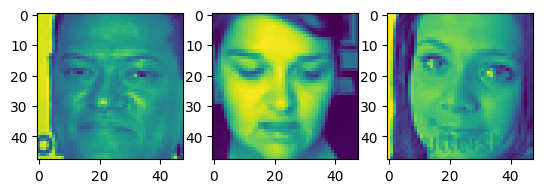

In [40]:
print('Example of non valid pixels :')

fig, ax = plt.subplots(1, 3)
ax[0].imshow(data_fixed['pixels'][1230].reshape(48,48))
ax[1].imshow(data_fixed['pixels'][27476].reshape(48,48))
ax[2].imshow(data_fixed['pixels'][22517].reshape(48,48))
plt.show()

In [ ]:
cropped_array_df = pd.DataFrame(cropped_array)

cropped_array_df.to_csv('data/output/csv/Cropped-Faces-DataFrame-from-4.3.4.csv', index = False)

cropped_array_df.head()

In [ ]:
from matplotlib import pyplot as plt

colors = ['red','white','blue','yellow','orange','green', 'black']

cmap = plt.cm.viridis

counts, bins, patches = plt.hist(cropped_array_df['emotion'], bins=7)

bin_centers = 0.5 * (bins[:-1] + bins[1:])
col = bin_centers - min(bin_centers)
col /= max(col)
for c, p in zip(col, patches):
    plt.setp(p, 'facecolor', cmap(c))

plt.show()

### Saving our result for finaly step ###

In [ ]:
#!zip -r 'Cropped-Faces-DataFrame-from-4.3.4.zip' '/content/mr.DGA/data/output/csv/Cropped Arrays'

In [43]:
#from google.colab import files
#files.download('/content/mr.DGA/Cropped-Faces-DataFrame-from-4.3.4.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Just Make Sure Everything os OK!

In [ ]:
#np.load('data/output/csv/Cropped Arrays/face_4.jpg_4.npy')

In [ ]:
#np.load('data/output/csv/Cropped Arrays/face_14.jpg_14.npy')

#### Load DataFrame With Pathes to arrays of cropped faces . To Make Sure !

In [94]:
df = pd.read_csv('data/output/csv/Cropped-Faces-DataFrame-from-4.3.4.csv')

In [ ]:
shuffled = df.sample(frac=1, random_state=1)
print("Shuffled DataFrame:\n", shuffled.head(3))

In [96]:
shuffled.set_index('index', inplace=True)

In [ ]:
print("Shuffled DataFrame:\n", shuffled.head(3))

Loaded array for face_33781.jpg from data/output/csv/Cropped Arrays/face_33781.jpg_33781.npy

  -->> Emotion Label -->>  6 


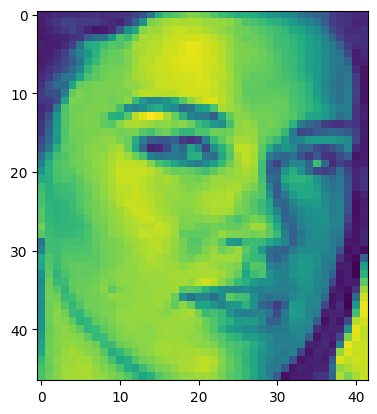

Loaded array for face_4216.jpg from data/output/csv/Cropped Arrays/face_4216.jpg_4216.npy

  -->> Emotion Label -->>  4 


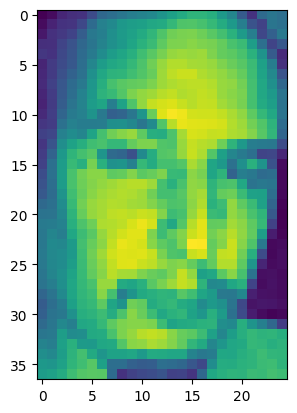

Loaded array for face_17781.jpg from data/output/csv/Cropped Arrays/face_17781.jpg_17781.npy

  -->> Emotion Label -->>  0 


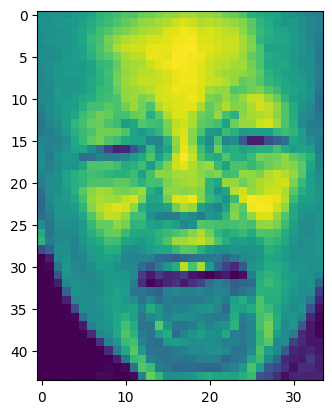

Loaded array for face_8969.jpg from data/output/csv/Cropped Arrays/face_8969.jpg_8969.npy

  -->> Emotion Label -->>  0 


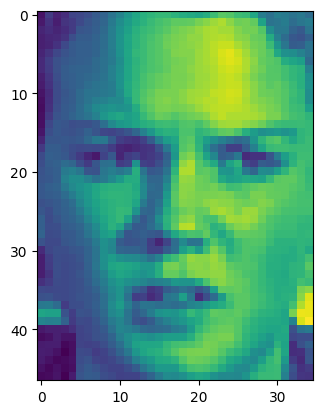

Loaded array for face_2492.jpg from data/output/csv/Cropped Arrays/face_2492.jpg_2492.npy

  -->> Emotion Label -->>  3 


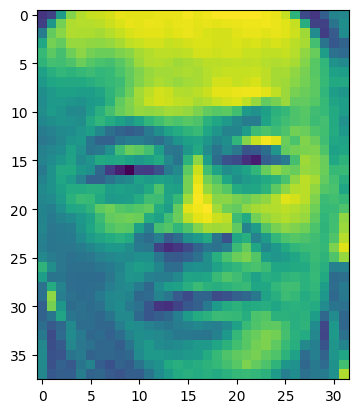

Loaded array for face_14225.jpg from data/output/csv/Cropped Arrays/face_14225.jpg_14225.npy

  -->> Emotion Label -->>  2 


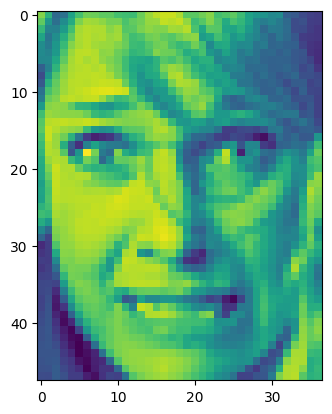

Loaded array for face_29429.jpg from data/output/csv/Cropped Arrays/face_29429.jpg_29429.npy

  -->> Emotion Label -->>  2 


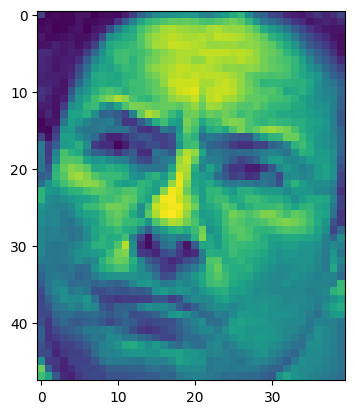

Loaded array for face_12644.jpg from data/output/csv/Cropped Arrays/face_12644.jpg_12644.npy

  -->> Emotion Label -->>  0 


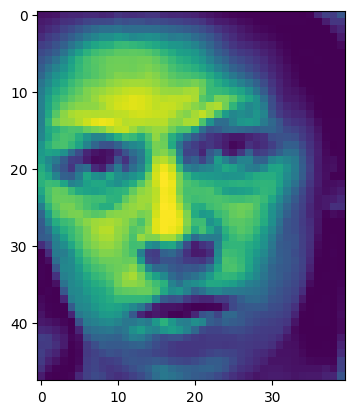

Loaded array for face_31001.jpg from data/output/csv/Cropped Arrays/face_31001.jpg_31001.npy

  -->> Emotion Label -->>  3 


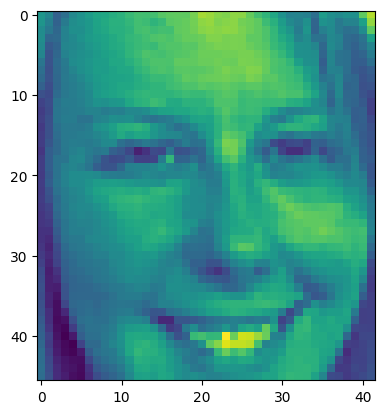

Loaded array for face_1196.jpg from data/output/csv/Cropped Arrays/face_1196.jpg_1196.npy

  -->> Emotion Label -->>  3 


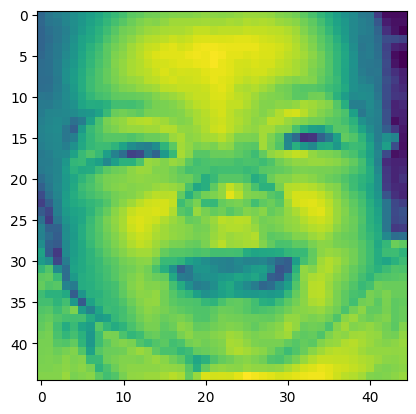

In [98]:
def load_array_from_path(path):
    return np.load(path)
df = shuffled
i = 0
lim = 10
# Loop through the DataFrame and load arrays
for idx, row in df.iterrows():
    i += 1
    array_path = row['pixel']
    array = load_array_from_path(f"data/output/csv/Cropped Arrays/face_{idx}.jpg_{idx}.npy")
    print(f"Loaded array for {row['name']} from {array_path}" )
    print('\n', f" -->> Emotion Label -->>  {row['emotion']} ")
    plt.imshow(array)
    plt.show()
    if i == lim:
      break


In [102]:
print(" The Final DataSet is Croped-Faces-Array.csv ")
print('')
print('         ^        ^          ^')
print('         ^        ^          ^ ')
print('         |        |          | ')
print('       ')
print("Now We Have Path to Our Images Which All of them Now Are Can be followd and will have been locating!!")
print('')

 The Final DataSet is Croped-Faces-Array.csv 

         ^        ^          ^
         ^        ^          ^ 
         |        |          | 
       
Now We Have Path to Our Images Which All of them Now Are Can be followd and will have been locating!!

